In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Flatten, Dense
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/tambet/.conda/envs/pommer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [5]:
data = np.load('simple_600K_disc0.99_cleaned.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((594333, 11, 11, 18), (594333,), (594333,))

In [6]:
data = np.load('valid_100K_disc0.99_cleaned.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((95623, 11, 11, 18), (95623,), (95623,))

In [7]:
x = Input(shape=(11,11,18))
h = Flatten()(x)
p = Dense(6, activation="softmax", name='p')(h)
v = Dense(1, activation="tanh", name='v')(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2178)         0           input_1[0][0]                    
__________________________________________________________________________________________________
p (Dense)                       (None, 6)            13074       flatten_1[0][0]                  
__________________________________________________________________________________________________
v (Dense)                       (None, 1)            2179        flatten_1[0][0]                  
Total params: 15,253
Trainable params: 15,253
Non-trainable params: 0
_______________________________________

In [8]:
history = model.fit(x_train, [p_train, v_train], batch_size=128, epochs=10, validation_data=(x_test, [p_test, v_test]))

Train on 594333 samples, validate on 95623 samples
Epoch 1/10
594333/594333 [==============================] - 17s 29us/step - loss: 3.0279 - p_loss: 1.5010 - v_loss: 0.1527 - p_acc: 0.3666 - val_loss: 3.0192 - val_p_loss: 1.4721 - val_v_loss: 0.1547 - val_p_acc: 0.3762
Epoch 2/10
594333/594333 [==============================] - 16s 27us/step - loss: 2.9657 - p_loss: 1.4512 - v_loss: 0.1514 - p_acc: 0.3903 - val_loss: 3.0443 - val_p_loss: 1.5404 - val_v_loss: 0.1504 - val_p_acc: 0.3683
Epoch 3/10
594333/594333 [==============================] - 16s 27us/step - loss: 2.9579 - p_loss: 1.4466 - v_loss: 0.1511 - p_acc: 0.3921 - val_loss: 3.5232 - val_p_loss: 1.5417 - val_v_loss: 0.1981 - val_p_acc: 0.3512
Epoch 4/10
594333/594333 [==============================] - 16s 27us/step - loss: 2.9666 - p_loss: 1.4457 - v_loss: 0.1521 - p_acc: 0.3922 - val_loss: 3.3368 - val_p_loss: 1.4831 - val_v_loss: 0.1854 - val_p_acc: 0.3801
Epoch 5/10
594333/594333 [==============================] - 16s 27us/

Text(0.5,1,'Value MSE')

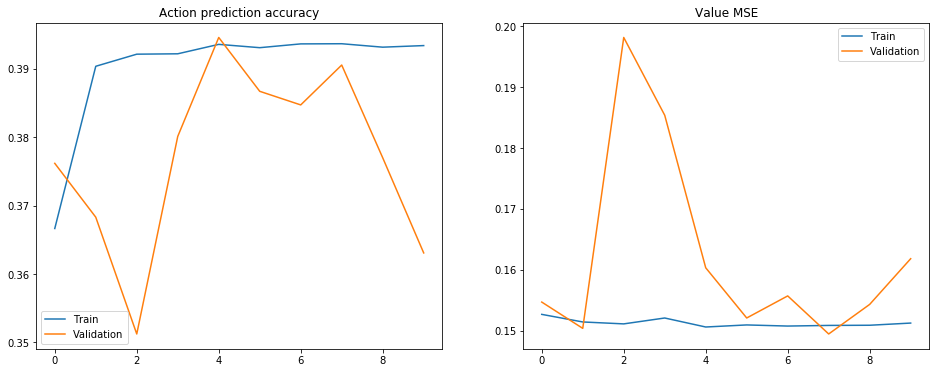

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [10]:
_, v_train_pred = model.predict(x_train)
_, v_test_pred = model.predict(x_test)
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Explained variance train: 0.012845516329725748
Explained variance test: -0.005572327426227375


In [11]:
model.save('linear.h5')